# Imports

In [3]:
%reload_ext autoreload
%autoreload 2
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
import json
from scipy.stats import pearsonr
import seaborn
sys.path.insert(0, '../')
from src.helper import *
# controls = ['negative_control','positive_control']
# grn_models = ['collectri','granie', 'figr', 'celloracle', 'scglue', 'scenicplus']

plt.rcParams['font.family'] = 'Liberation Sans'

results_folder = '../results_folder'
task_grn_inference_dir = '../../task_grn_inference'
scores_dir = '../../task_grn_inference/resources/scores'

datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

%matplotlib inline

# Scores

In [14]:
!ls {scores_dir}/op

50000-skeleton_False-binarize_True-ridge.csv
lognorm-50000-skeleton_False-binarize_True-ridge-global-False.csv
nets
X_norm-50000-skeleton_False-binarize_True-GB-global-False.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv


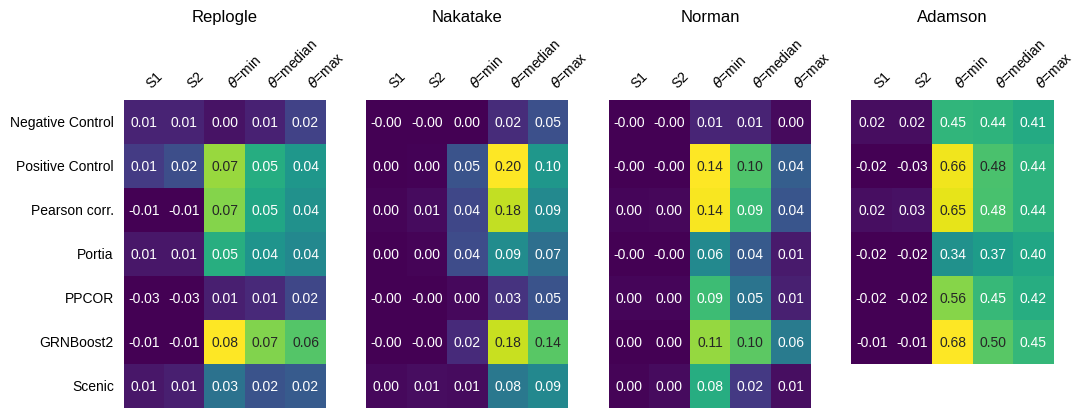

In [7]:
# - raw scores for all datasets - ridge
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
for i, dataset in enumerate(datasets[1:]):
    scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)

    if 'scenic' not in scores_mat.index:
        scores_mat.loc['scenic',:] = np.nan
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)



    ax = axes[i]
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_title(f'{surragate_names[dataset]}', pad=10, fontsize=12)
    
# fig.suptitle('(A) Regression scores', y=1.2, fontsize=12, fontweight='bold')
# scores_ridge
# fig.savefig(f"{results_folder}/benchmark/figs/benchmark_scores_skeleton_binarized.png", dpi=300, transparent=True, bbox_inches='tight')

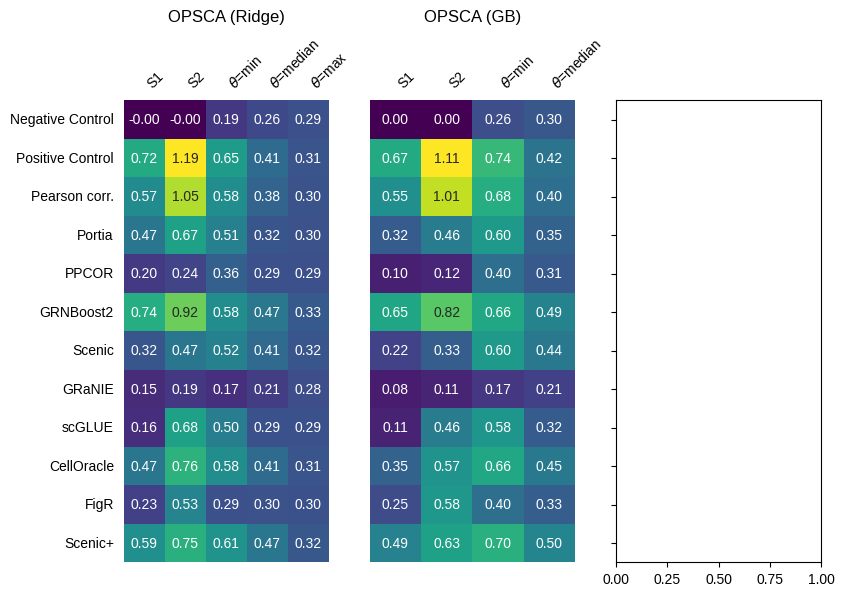

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(9, 6), sharey=True)
dataset = 'op'
for i, reg_type in enumerate(['ridge', 'GB']):
    scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-{reg_type}-global-False.csv', index_col=0)
    if 'collectri' in scores_mat.index:
        scores_mat = scores_mat.drop('collectri')
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)

    ax = axes[i]
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_title(f"{surragate_names[dataset]} ({reg_type.capitalize() if not reg_type.isupper() else reg_type})", pad=10, fontsize=12)

# flobal 
# scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_True-binarize_True-ridge-global-False.csv', index_col=0)
# scores_mat.columns = scores_mat.columns.map(surragate_names)
# scores_mat.index = scores_mat.index.map(surragate_names)

# ax = axes[i]
# plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]} (Ridge)-(Skeleton applied)", pad=10, fontsize=12)

# fig.suptitle('(A) Regression scores (ridge)', y=1.2, fontsize=12, fontweight='bold')

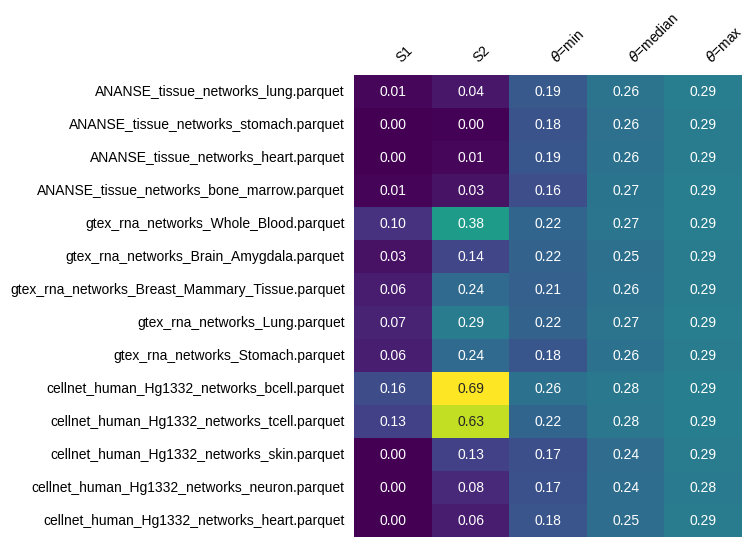

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(5, 6), sharey=False)
dataset='op'
ax = axes
scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
# scores_mat.index = scores_mat.index.map(surragate_names)


plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]} (Ridge)-(Skeleton applied)", pad=10, fontsize=12)

In [16]:
!sacct 

JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
7804343          vscode        gpu       biim         20    RUNNING      0:0 
7804343.bat+      batch                  biim         20    RUNNING      0:0 
7804343.ext+     extern                  biim         20    RUNNING      0:0 
7849254          scores        cpu       biim         20     FAILED      1:0 
7849254.bat+      batch                  biim         20     FAILED      1:0 
7849254.ext+     extern                  biim         20  COMPLETED      0:0 


# Robustness analysis

In [9]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

In [10]:
base_dir = '../../task_grn_inference/resources/results/robustness_analysis'
figsize=(3.5, 3)

### TF-gene links

In [11]:
noise_type = 'net'
reg1_mat_net, reg2_mat_net = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'sign'
reg1_mat_sign, reg2_mat_sign = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'weight'
reg1_mat_weight, reg2_mat_weight = format_robustness_results(base_dir, noise_type=noise_type)


/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_91808/2112841291.py:29: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g = sns.catplot(
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_91808/2112841291.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_91808/2112841291.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_91808/2112841291.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xtickla

<Figure size 1000x600 with 0 Axes>

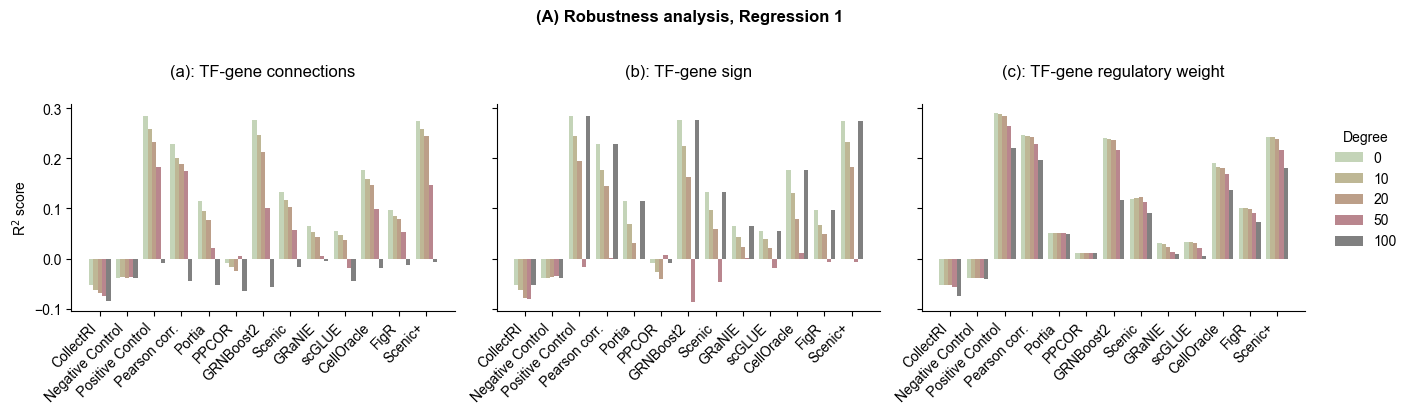

<Figure size 1000x600 with 0 Axes>

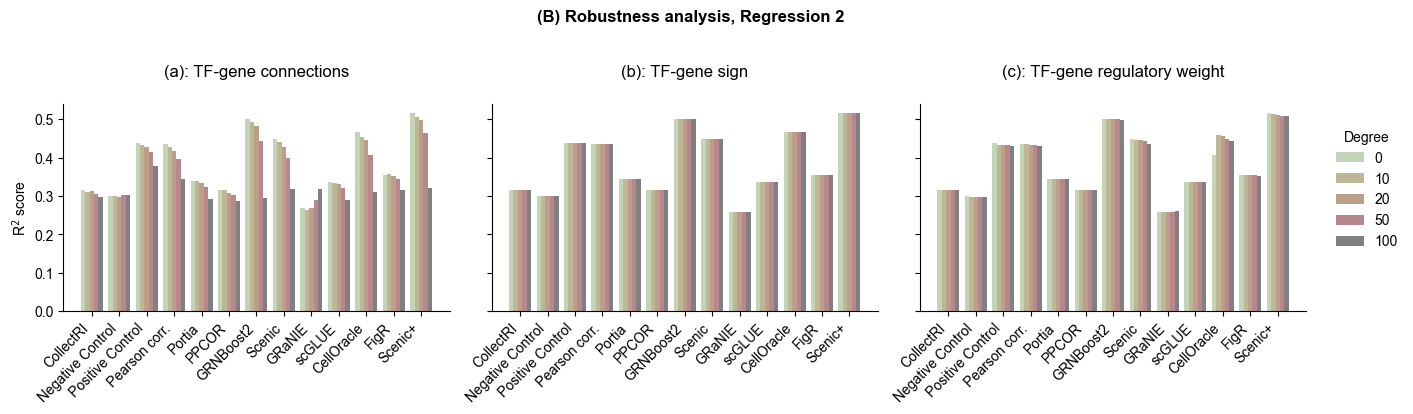

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_robustness(reg_mat_net, reg_mat_sign, reg_mat_weight, title):
    reg_mat_net['Permute type'] = 'TF-gene connections'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene regulatory weight'


    # Concatenate the DataFrames
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight])
    
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))
    # print(df_concat)

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_melt = pd.melt(df_concat, id_vars=['Degree', 'Permute type'], 
                    var_name='method', value_name=r'R$^2$ score')

    df_melt = df_melt[df_melt.method!='Degree']

    plt.figure(figsize=(10, 6))

    # Create a bar plot where noise types are nested within methods
    g = sns.catplot(
        data=df_melt, 
        x='method', 
        y=r'R$^2$ score', 
        hue='Degree', 
        col='Permute type', 
        kind='bar',
        height=3, 
        # width=6, 
        aspect=1.4,
        palette=colors_cell_type,
        legend_out=True
    )

    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Degree", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('Permute type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
    plt.suptitle(title, y=1.2,  fontsize=12, fontweight='bold')
plot_robustness(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, '(A) Robustness analysis, Regression 1')
plt.savefig(f"{results_folder}/benchmark/figs/robustness_reg1.png", dpi=300, transparent=True, bbox_inches='tight')
plot_robustness(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, '(B) Robustness analysis, Regression 2')
plt.savefig(f"{results_folder}/benchmark/figs/robustness_reg2.png", dpi=300, transparent=True, bbox_inches='tight')
